Train: 0.831, Test: 0.860


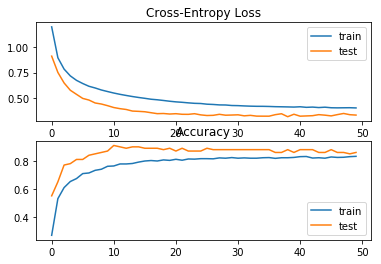

In [5]:
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

y = to_categorical(y)

n_train = int(0.9 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=0)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [11]:

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy


def evaluate_model(trainX, trainy, testX, testy):
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc

def ensemble_predictions(members, testX):
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	summed = numpy.sum(yhats, axis=0)
	result = argmax(summed, axis=1)
	return result

def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# split data
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

KeyboardInterrupt: 

>0.844
>0.868
>0.820
>0.816
>0.832
>0.806
>0.816
>0.840
>0.820
>0.814
Estimated Accuracy 0.828 (0.018)
> 1: single=0.820, ensemble=0.820
> 2: single=0.821, ensemble=0.821
> 3: single=0.820, ensemble=0.820
> 4: single=0.820, ensemble=0.820
> 5: single=0.820, ensemble=0.820
> 6: single=0.820, ensemble=0.820
> 7: single=0.821, ensemble=0.820
> 8: single=0.820, ensemble=0.820
> 9: single=0.819, ensemble=0.820
> 10: single=0.820, ensemble=0.820
Accuracy 0.820 (0.000)


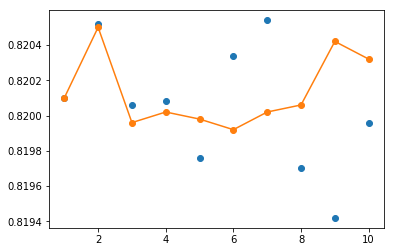

In [12]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy


def evaluate_model(trainX, trainy, testX, testy):
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc


def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result


def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)


dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

n_folds = 10
kfold = KFold(n_folds, True, 1)

scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
	# select samples
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

single_scores, ensemble_scores = list(), list()
for i in range(1, n_folds+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

>0.820
>0.831
>0.840
>0.828
>0.822
>0.816
>0.824
>0.834
>0.826
>0.825
Estimated Accuracy 0.826 (0.007)
> 1: single=0.820, ensemble=0.820
> 2: single=0.819, ensemble=0.820
> 3: single=0.819, ensemble=0.820
> 4: single=0.820, ensemble=0.820
> 5: single=0.819, ensemble=0.821
> 6: single=0.819, ensemble=0.821
> 7: single=0.819, ensemble=0.821
> 8: single=0.820, ensemble=0.821
> 9: single=0.818, ensemble=0.820
> 10: single=0.819, ensemble=0.820
Accuracy 0.819 (0.001)


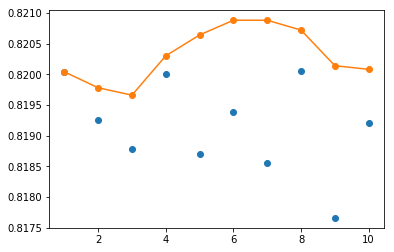

In [2]:
from sklearn.datasets import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy


def evaluate_model(trainX, trainy, testX, testy):
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc


def ensemble_predictions(members, testX):
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	summed = numpy.sum(yhats, axis=0)
	result = argmax(summed, axis=1)
	return result


def evaluate_n_members(members, n_members, testX, testy):
	subset = members[:n_members]
	yhat = ensemble_predictions(subset, testX)
	return accuracy_score(testy, yhat)

dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	ix = [i for i in range(len(X))]
	train_ix = resample(ix, replace=True, n_samples=4500)
	test_ix = [x for x in ix if x not in train_ix]
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()